In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from einops import rearrange
import random
import decord
import cv2
try: 
    import torchvision.transforms._transforms_video as transforms_video
except:
    import torchvision.transforms as transforms_video

import lovely_tensors 
lovely_tensors.monkey_patch()

%load_ext autoreload
%autoreload all

torch.set_grad_enabled(False)

/root/przemek/miniconda3/envs/dora/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/root/przemek/miniconda3/envs/dora/lib/python3.8/site-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/root/przemek/miniconda3/envs/dora/lib/python3.8/site-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(


In [6]:
# load model

from utils import load_pretrained_weights, MultiCropWrapper
import vision_transformer as vits
from vision_transformer import DINOHead

MODEL_ARCH = "vit_small"
PATCH_SIZE = 16

model = vits.__dict__[MODEL_ARCH](patch_size=PATCH_SIZE)
load_pretrained_weights(
    model, 
    pretrained_weights="checkpoint_WT-all.pth", 
    checkpoint_key="teacher", 
    model_name=MODEL_ARCH, 
    patch_size=PATCH_SIZE
)
model = model.cuda().eval()

Take key teacher in provided checkpoint dict
Pretrained weights found at checkpoint_WT-all.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])


In [49]:
# load video
filename = "vids/venice_3_narrow_street.mp4"
reader = decord.VideoReader(filename,
            ctx=decord.cpu(0),
            num_threads=1)

frame_indices = np.arange(0, 600, dtype=int)
video_raw = reader.get_batch(frame_indices).asnumpy()
video_raw = torch.from_numpy(video_raw)
video_raw

tensor[600, 720, 1280, 3] u8 n=1658880000 (1.5Gb) x∈[0, 255] μ=110.351 σ=62.970

tensor[3, 600, 224, 224] n=90316800 (0.3Gb) x∈[-2.118, 2.640] μ=-0.072 σ=1.092 cuda:0


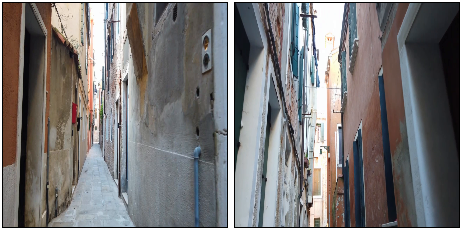

In [50]:
# transform video

NORMALIZE_STATS = (
    (0.485, 0.456, 0.406), 
    (0.229, 0.224, 0.225)
)

transform = transforms.Compose([
    transforms_video.ToTensorVideo(),
    transforms.Resize([224, 224]),
    transforms.CenterCrop(224),
    transforms_video.NormalizeVideo(*NORMALIZE_STATS),
])

video = transform(video_raw).cuda()

print(video)
video[:, [0, -1]].transpose(0, 1).rgb(NORMALIZE_STATS)

In [51]:
from math import sqrt
from sinkhorn_knopp import SinkhornKnopp

SK = SinkhornKnopp(num_iters_sk=30, epsilon_sk=0.05).cuda()
k_random_heads=3

frames = rearrange(video, "c t h w -> t c h w")

_, patches, attn, query, key = model(frames)

# normalized patch embeddings 
patch_embeddings = patches[None, :, 1:, :] 
patch_embeddings /= patch_embeddings.norm(dim=-1, keepdim=True)  # [b t n d]

# attention from cls token to patches
cls_to_patch_attn = attn[None, :, :, 0, 1:]  # [b t h n]

# query values for patches (non cls token)
patch_queries = rearrange(query[None, :, :, 1:, :], "b t h n hd -> b t n (h hd)")  # [b t n d]

# key values for patches (non cls token)
patch_keys = rearrange(key[None, :, :, 1:, :], "b t h n hd -> b t n (h hd)")  # [b t n d]

# sampling k random heads (paper page 5 at the bottom)
if k_random_heads:
    random_heads = random.sample(range(cls_to_patch_attn.size(2)), k_random_heads) 
    cls_to_patch_attn = cls_to_patch_attn[:, :, random_heads]  # [b t k n]

# object prototypes (paper eq. 2) 
obj_prototypes = cls_to_patch_attn @ patch_queries  # [b t k d]

# transport plan (paper eq. 4)
transport_plan = SK(obj_prototypes @ patch_embeddings.transpose(-2, -1))  # [b t k n]

# refined object prototypes (paper eq. 5) 
ref_obj_prototypes = transport_plan @ patch_embeddings # [b t k d]

# object prototypes from the first frame to be tracked on others
first_frame_prototypes = ref_obj_prototypes[:, :1, :, :]  # [b 1 k d]

# refined cross-attention maps (paper eq. 6) 
d = first_frame_prototypes.size(-1)
attn_maps = torch.softmax(
    first_frame_prototypes @ patch_keys.transpose(-2, -1) / sqrt(d),
    dim=-1
) # [b t k n]

attn_maps/= attn_maps.norm(dim=-1, keepdim=True)
masks = (attn_maps > attn_maps.mean(dim=-1, keepdim=True)).float()

tensor[1, 600, 3, 196] n=352800 (1.3Mb) x∈[0., 1.000] μ=0.478 σ=0.499 cuda:0


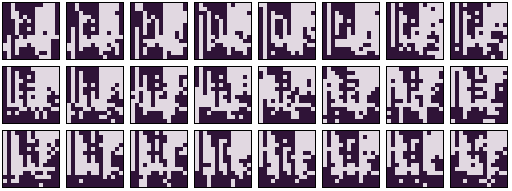

In [52]:
print(masks)
masks[:,:24,1].reshape(-1,14,14).chans(scale=4)

In [53]:
# smoothing out masks
kernel_size = 5
b, t, k, n = masks.size()
window = torch.tensor(np.hanning(kernel_size), dtype=torch.float32).view(1, 1, kernel_size) / np.hanning(kernel_size).sum()
masks = masks.permute(0, 2, 3, 1).reshape(-1, t)  # [b*k*n, t]
masks = F.conv1d(masks.unsqueeze(1).cpu(), window, padding=kernel_size // 2).view(b, k, n, t).permute(0, 3, 1, 2)
masks

tensor[1, 600, 3, 196] n=352800 (1.3Mb) x∈[0., 1.000] μ=0.477 σ=0.459

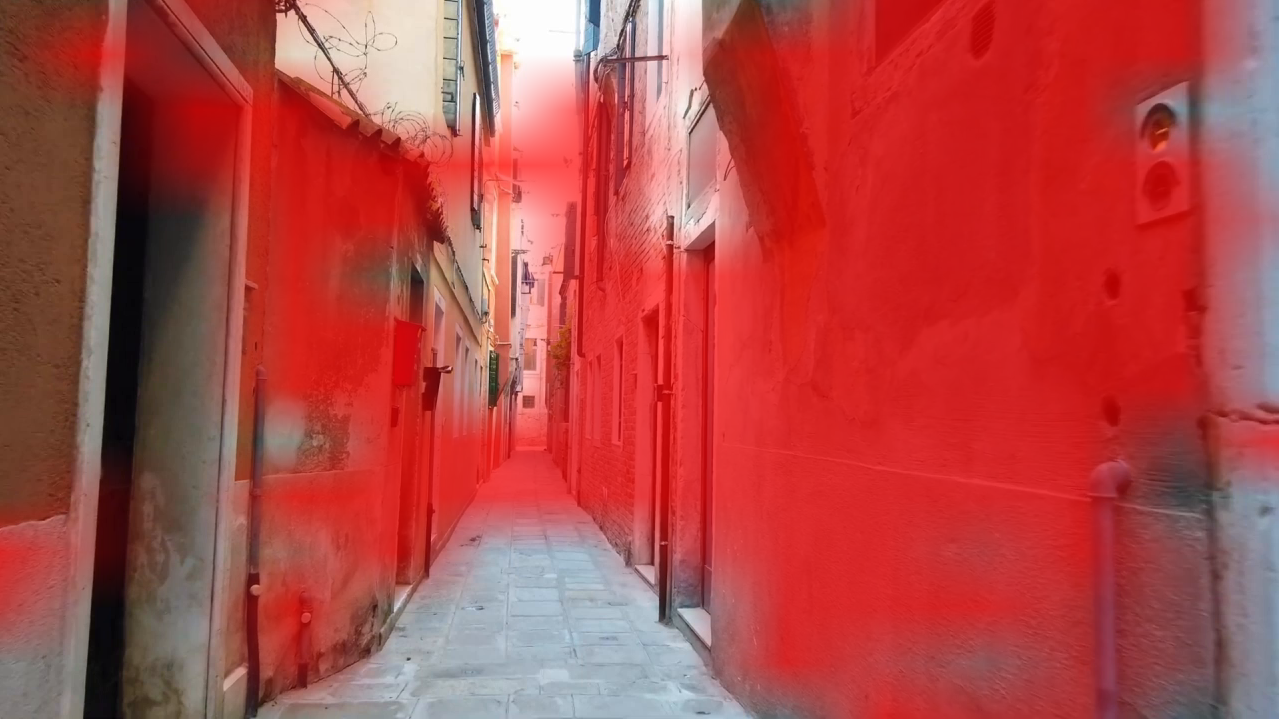

In [58]:
b, t, k, n = masks.size()

h = w = int(sqrt(n))
which_head = 2
some_mask = masks.view(b, t, k, h, w)[0, :, [which_head]]

overlay = F.interpolate(some_mask.clamp(0, 0.7), size=(720, 1280), mode='bilinear', align_corners=True).cpu()

video_out = TF.resize(video_raw.permute(0, 3, 1, 2).float()/255, 720)

R = torch.tensor([1, 0, 0]).reshape(1, 3, 1, 1)

video_out = video_out * (1 - overlay) + R * overlay

video_out[0].rgb

In [59]:
def save_tensor_as_video(tensor, video_filename, fps=60):
    tensor = (tensor * 255).byte().flip(1) 
    tensor = tensor.permute(0, 2, 3, 1).numpy() 
    
    height, width = tensor.shape[1:3]
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video_writer = cv2.VideoWriter(video_filename, fourcc, fps, (width, height))
    
    for frame in tensor:
        video_writer.write(frame)
    
    video_writer.release()

save_tensor_as_video(video_out, 'venice_narrow_2.mp4', fps=30)